# 08. PyTorch Paper Replicating Exercises

## 0. Resources

These exercises/solutions are based on section 08. PyTorch Paper Replicating of the Learn PyTorch for Deep Learning course by Zero to Mastery: https://www.learnpytorch.io/08_pytorch_paper_replicating/

## 1. Get various imports and helper functions

In [1]:
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

import matplotlib.pylab as plt

from src import get_data, setup_data, engine

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else (
    "mps" if torch.mps.is_available() else "cpu"
)
device

'mps'

## 2. Get data

In [3]:
# Download data
get_data.get_data(data_dir_str="data",
                  image_path_str="pizza_steak_sushi",
                  data_url_str="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                  file_name_str="pizza_steak_sushi.zip")

data/pizza_steak_sushi exists...
Data in data/pizza_steak_sushi already exits, skipping downloading and unzipping...
Finished getting data...


In [4]:
# Setup directories
from pathlib import Path

train_dir = Path("data/pizza_steak_sushi/train")
test_dir = Path("data/pizza_steak_sushi/test")

In [5]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 3. Preprocess data

In [6]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = setup_data.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(2))

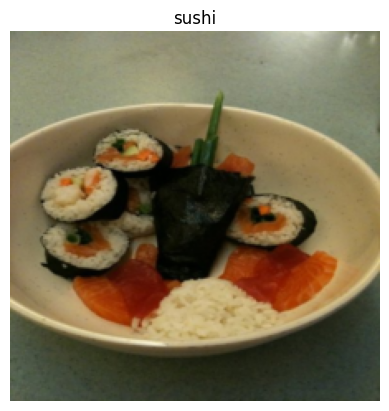

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);


## 4. Replicate the ViT architecture we created with in-built PyTorch transformer layers.

* You'll want to look into replacing our `TransformerEncoderBlock()` class with `torch.nn.TransformerEncoderLayer()` (these contain the same layers as our custom blocks)
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with `torch.nn.TransformerEncoder()`

In [ ]:
# TODO: your code

## 5. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like `from vit import ViT`
* We covered the art of turning code cells into Python scrips in 05. PyTorch Going Modular

In [ ]:
# TODO: your code

## 6. Train a pretrained ViT feature extractor model (like the one we made in 08. PyTorch Paper Replicating section 10) on 20% of the pizza, steak and sushi data like the dataset we used in 07. PyTorch Experiment Tracking section 7.3

* See how it performs compared to the EffNetB2 model we compared it to in 08. PyTorch Paper Replicating section 10.6.

In [ ]:
# TODO: your code

## 7. Try repeating the steps from excercise 3 but this time use the `ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1` pretrained weights from `torchvision.models.vit_b_16()`.

* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights .transforms() method.

In [ ]:
# TODO: your code